In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import qqplot,add_constant
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import graphviz
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from matplotlib import gridspec
%matplotlib inline

#경고문구 무시
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rc('font',family='NanumGothic')

# 데이터 전처리

In [14]:
df=pd.read_csv('BOSTON_HOUSING.csv',engine='python',encoding='949')
df.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.000000,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98
1,21.600000,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14
2,34.700001,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03
3,33.400002,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94
4,36.200001,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33


In [15]:
#결측치 확인

df.isnull().sum()

#결측치는 없음

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

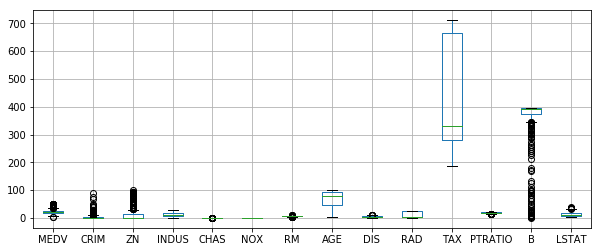

In [16]:
#이상치 확인
df.boxplot(figsize=(10,4))

In [17]:
q3=df.quantile(0.75).round(3)
q1=df.quantile(0.25).round(3)
iqr=q3-q1
lower_bound=q1-(1.5*iqr)
upper_bound=q3+(1.5*iqr)

x=['MEDV','CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
for i in x:
    a=df[i][(df[i]<=lower_bound[i]) | (df[i]>=upper_bound[i])].count()
    if a !=0:
        print(i,a)
        
# IQR을 기준을 이상치 갯수를 검색하였다. 
# CHAS는 강 조망 여부 이므로 이상치는 무시한다.
#이상치가 가장 많은 B를 다시 분석한다.

MEDV 40
CRIM 66
ZN 68
CHAS 506
RM 30
DIS 5
PTRATIO 15
B 77
LSTAT 7


In [18]:
df.corr(method='pearson').round(3)

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
MEDV,1.000,-0.388,0.360,-0.484,0.175,-0.427,0.695,-0.377,0.250,-0.382,-0.469,-0.508,0.333,-0.738
CRIM,-0.388,1.000,-0.200,0.407,-0.056,0.421,-0.219,0.353,-0.380,0.626,0.583,0.290,-0.385,0.456
ZN,0.360,-0.200,1.000,-0.534,-0.043,-0.517,0.312,-0.570,0.664,-0.312,-0.315,-0.392,0.176,-0.413
INDUS,-0.484,0.407,-0.534,1.000,0.063,0.764,-0.392,0.645,-0.708,0.595,0.721,0.383,-0.357,0.604
CHAS,0.175,-0.056,-0.043,0.063,1.000,0.091,0.091,0.087,-0.099,-0.007,-0.036,-0.122,0.049,-0.054
NOX,-0.427,0.421,-0.517,0.764,0.091,1.000,-0.302,0.731,-0.769,0.611,0.668,0.189,-0.380,0.591
RM,0.695,-0.219,0.312,-0.392,0.091,-0.302,1.000,-0.240,0.205,-0.210,-0.292,-0.356,0.128,-0.614
AGE,-0.377,0.353,-0.570,0.645,0.087,0.731,-0.240,1.000,-0.748,0.456,0.506,0.262,-0.274,0.602
DIS,0.250,-0.380,0.664,-0.708,-0.099,-0.769,0.205,-0.748,1.000,-0.495,-0.534,-0.232,0.292,-0.497
RAD,-0.382,0.626,-0.312,0.595,-0.007,0.611,-0.210,0.456,-0.495,1.000,0.910,0.465,-0.444,0.489


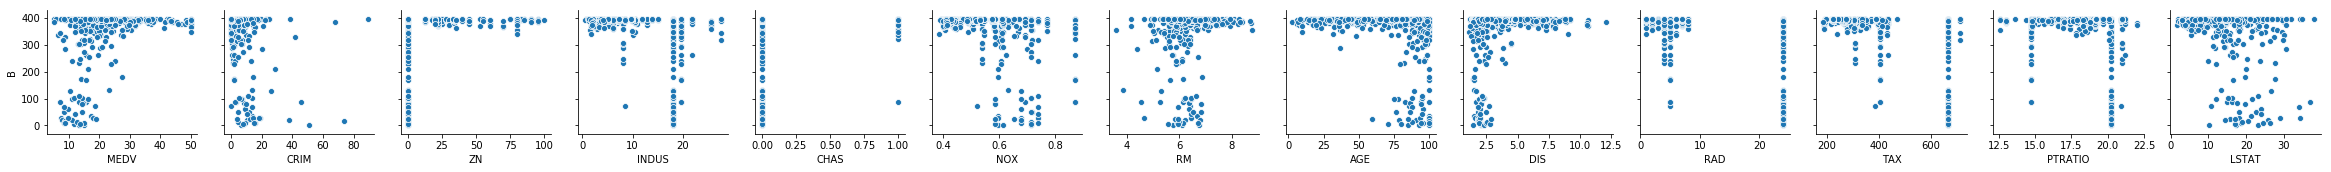

In [23]:
# 상관관계 분석

display(sns.pairplot(df,y_vars=['B'],x_vars=['MEDV','CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','LSTAT']))

df.corr(method='pearson').round(3)

df=df.drop(['B'],axis=1)

# B와 다른 변수간의 상관관계를 분석한 결과 상관계수가 0.5보다 작으므로 변수간의 상관정도가 낮다.
#이상치도 많으며 다른 변수와의 상관관계까 낮으므로 변수 B를 제거한다.

In [10]:
df.corr(method='pearson').round(3)

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
MEDV,1.000,-0.388,0.360,-0.484,0.175,-0.427,0.695,-0.377,0.250,-0.382,-0.469,-0.508,-0.738
CRIM,-0.388,1.000,-0.200,0.407,-0.056,0.421,-0.219,0.353,-0.380,0.626,0.583,0.290,0.456
ZN,0.360,-0.200,1.000,-0.534,-0.043,-0.517,0.312,-0.570,0.664,-0.312,-0.315,-0.392,-0.413
INDUS,-0.484,0.407,-0.534,1.000,0.063,0.764,-0.392,0.645,-0.708,0.595,0.721,0.383,0.604
CHAS,0.175,-0.056,-0.043,0.063,1.000,0.091,0.091,0.087,-0.099,-0.007,-0.036,-0.122,-0.054
NOX,-0.427,0.421,-0.517,0.764,0.091,1.000,-0.302,0.731,-0.769,0.611,0.668,0.189,0.591
RM,0.695,-0.219,0.312,-0.392,0.091,-0.302,1.000,-0.240,0.205,-0.210,-0.292,-0.356,-0.614
AGE,-0.377,0.353,-0.570,0.645,0.087,0.731,-0.240,1.000,-0.748,0.456,0.506,0.262,0.602
DIS,0.250,-0.380,0.664,-0.708,-0.099,-0.769,0.205,-0.748,1.000,-0.495,-0.534,-0.232,-0.497
RAD,-0.382,0.626,-0.312,0.595,-0.007,0.611,-0.210,0.456,-0.495,1.000,0.910,0.465,0.489


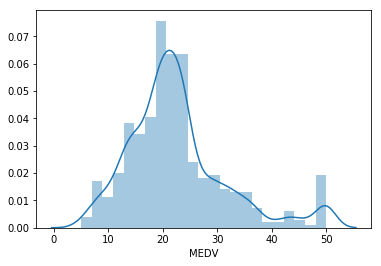

In [19]:
sns.distplot(df['MEDV'])

In [20]:
df['MEDV'].describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200001
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

# 회귀분석

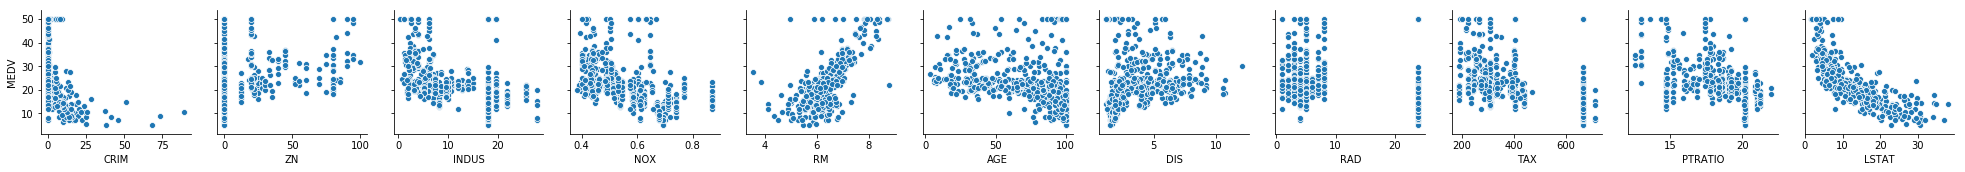

In [24]:

sns.pairplot(df,y_vars=['MEDV'],x_vars=['CRIM','ZN','INDUS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','LSTAT'])
df_x=df.drop(['MEDV','CHAS'],axis=1)
df_y=df['MEDV']

#목표변수와 설명변수들 간의 관계를 그래프로 확인 해본 결과 NOX가 영의 상관관계를 가지고 있다.
#또한 LSTAT 변수는 음의 상관관계가 보여진다.
#0과 1밖에 없는 CHAS변수는 회귀분석에서 제거한다.

In [25]:
df_x.corr(method='pearson').round(3)

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
CRIM,1.000,-0.200,0.407,0.421,-0.219,0.353,-0.380,0.626,0.583,0.290,0.456
ZN,-0.200,1.000,-0.534,-0.517,0.312,-0.570,0.664,-0.312,-0.315,-0.392,-0.413
INDUS,0.407,-0.534,1.000,0.764,-0.392,0.645,-0.708,0.595,0.721,0.383,0.604
NOX,0.421,-0.517,0.764,1.000,-0.302,0.731,-0.769,0.611,0.668,0.189,0.591
RM,-0.219,0.312,-0.392,-0.302,1.000,-0.240,0.205,-0.210,-0.292,-0.356,-0.614
AGE,0.353,-0.570,0.645,0.731,-0.240,1.000,-0.748,0.456,0.506,0.262,0.602
DIS,-0.380,0.664,-0.708,-0.769,0.205,-0.748,1.000,-0.495,-0.534,-0.232,-0.497
RAD,0.626,-0.312,0.595,0.611,-0.210,0.456,-0.495,1.000,0.910,0.465,0.489
TAX,0.583,-0.315,0.721,0.668,-0.292,0.506,-0.534,0.910,1.000,0.461,0.544
PTRATIO,0.290,-0.392,0.383,0.189,-0.356,0.262,-0.232,0.465,0.461,1.000,0.374


In [20]:
reg_model=smf.ols(formula='MEDV ~CRIM+ZN+INDUS+NOX+RM+AGE+DIS+RAD+TAX+PTRATIO+LSTAT',data=df)
reg_result=reg_model.fit()
print(reg_result.summary())

#회귀식의 p값이 0.05보다 작으므로 회귀식은 유의하다.
#R값이 0.7이상 이므로 회귀식의 설명력이 높다.
#그러나 INDUS,AGE의 p값이 0.05보다 크므로 회귀계수에 유의하지 않다.

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     120.5
Date:                Fri, 03 May 2019   Prob (F-statistic):          3.71e-132
Time:                        21:31:37   Log-Likelihood:                -1510.3
No. Observations:                 506   AIC:                             3045.
Df Residuals:                     494   BIC:                             3095.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.3279      4.979      8.501      0.0

In [21]:
df_x=df.drop(['MEDV','CHAS'],axis=1)
df_x_const=add_constant(df_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_x_const.values,i)for i in range(df_x_const.shape[1])]
df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

#TAX의 VIF값이 가장 크다.

,variable,VIF
1,CRIM,1.762
10,PTRATIO,1.782
5,RM,1.911
2,ZN,2.298
11,LSTAT,2.857
6,AGE,3.079
3,INDUS,3.946
7,DIS,3.953
4,NOX,4.365
8,RAD,7.364


In [22]:
df_x=df.drop(['MEDV','CHAS','TAX'],axis=1)
df_x_const=add_constant(df_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_x_const.values,i)for i in range(df_x_const.shape[1])]
df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

#다중공선성이 높은 TAX를 제거하였다. 나머지 변수들의 상관관계는 낮아졌다.

,variable,VIF
1,CRIM,1.762
9,PTRATIO,1.768
5,RM,1.900
2,ZN,2.184
8,RAD,2.772
10,LSTAT,2.857
6,AGE,3.078
3,INDUS,3.209
7,DIS,3.951
4,NOX,4.341


In [29]:
df_y=df['MEDV']
model=LinearRegression()
rfe=RFE(estimator=model,n_features_to_select=7).fit(df_x,df_y)
selected_cols=df_x.columns[rfe.support_]
removed_cols=df_x.columns[~rfe.support_]
print('selected variable : {}'.format(selected_cols))
print('removed variable : {}'.format(removed_cols))

#후진제거법을 사용하여 최적의 변수를 선택하였다.

selected variable : Index(['CRIM', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO', 'LSTAT'], dtype='object')
removed variable : Index(['ZN', 'INDUS', 'AGE', 'TAX'], dtype='object')


In [30]:
rfe_reg_model=smf.ols(formula='MEDV~CRIM+NOX+RM+DIS+RAD+PTRATIO+LSTAT',data=df)
rfe_reg_result=rfe_reg_model.fit()
print(rfe_reg_result.summary())

#처음 전체 변수를 넣고 만든 회귀식 보다 ADJ_R값이 약간 낮아졌지만 여전히 0.7이상으로 설명력이 높다.
#p값이 0.05이하이므로 다음 회귀식은 유의하다.
#모든 설명변수의 p값이 0.05보다 작으므로 모두 회귀식에 유의하다.

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     179.6
Date:                Sat, 04 May 2019   Prob (F-statistic):          7.58e-132
Time:                        21:05:00   Log-Likelihood:                -1521.5
No. Observations:                 506   AIC:                             3059.
Df Residuals:                     498   BIC:                             3093.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.2605      5.022      8.216      0.0

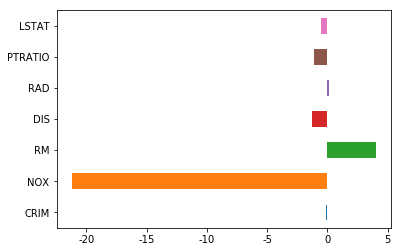

In [31]:
df_coef=pd.DataFrame({'Coef':rfe_reg_result.params.values[1:]},\
                         index=selected_cols)
df_coef.plot.barh(y='Coef',legend=False)

In [30]:
df_x=df.drop(['MEDV','TAX','ZN', 'INDUS', 'AGE','CHAS'],axis=1)
df_x_const=add_constant(df_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_x_const.values,i)for i in range(df_x_const.shape[1])]
df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

#최종모델의 VIF를 확인한 결과 모두 5이하 이므로 다중공선성이 낮다.

,variable,VIF
6,PTRATIO,1.524
1,CRIM,1.744
3,RM,1.762
7,LSTAT,2.517
4,DIS,2.567
5,RAD,2.655
2,NOX,3.512
0,const,524.441


In [31]:
#최종회귀식
# y(MEDV)=40.8089-0.1106CRIM-21.9551NOX+3.9902RM-1.1996DIS+0.1188RAD-1.1154PTRATIO-0.5520LSTAT

In [32]:
scaler=StandardScaler()
cols=df_x.columns
np_scaled=scaler.fit_transform(df_x)
df_scaled=pd.DataFrame(np_scaled,columns=cols)
df_scaled['MEDV']=df['MEDV']
reg_model_scaled=smf.ols(formula='MEDV~CRIM+NOX+RM+DIS+RAD+PTRATIO+LSTAT',data=df_scaled)
reg_result_scaled=reg_model_scaled.fit()
print(reg_result_scaled.summary())

# 스케일을 한 후 다시 분석해도 결과는 바뀌지 않았다. 

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     179.6
Date:                Fri, 03 May 2019   Prob (F-statistic):          7.58e-132
Time:                        21:35:43   Log-Likelihood:                -1521.5
No. Observations:                 506   AIC:                             3059.
Df Residuals:                     498   BIC:                             3093.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.5328      0.219    102.748      0.0

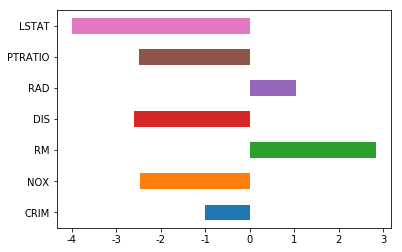

In [33]:
df_reg_coef=pd.DataFrame({'Coef':reg_result_scaled.params.values[1:]},\
                         index=selected_cols)
df_reg_coef.plot.barh(y='Coef',legend=False)

# 최종결과 
# 저소득층 비율이 작을수록 주택가격이 상승
# 학생당 교사 비율이 작을수록 주택가격이 상승
# 고속도로 접근 편이성 지수가 높을수록 주택가격이 상승
# 중심지 접근거리가 낮을수록 주택가격이 상승
# 주거당 평균 객실 수가 높을수록 주택가격이 상승
# 산화질소 농도가 낮을수록 주택가격이 상승
# 범죄율이 낮으면  주택가격이 상승



# 랜덤포레스트

In [55]:
#데이터 분할
df=pd.read_csv('BOSTON_HOUSING.csv',engine='python',encoding='949')
df_y=df['MEDV']
df_x=df.drop(['MEDV','B'],axis=1,inplace=False)

df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_x,df_y,test_size=0.6,random_state=1234)
df_vaild_x,df_testx,df_vaild_y,df_testy=train_test_split(df_test_x,df_test_y,test_size=0.5,random_state=1234)

print('train data x size:{}'.format(df_train_x.shape))
print('train data y size:{}'.format(df_train_y.shape))
print('test data x size:{}'.format(df_testx.shape))
print('test data y size:{}'.format(df_testy.shape))
print('vaild data x size:{}'.format(df_vaild_x.shape))
print('vaild data y size:{}'.format(df_vaild_y.shape))


train data x size:(202, 12)
train data y size:(202,)
test data x size:(152, 12)
test data y size:(152,)
vaild data x size:(152, 12)
vaild data y size:(152,)


In [56]:
#기본 모델 

rf_un=RandomForestRegressor(random_state=1234)
rf_un.fit(df_train_x,df_train_y)
print('score on training set:{:.3f}'.format(rf_un.score(df_train_x,df_train_y)))
print('score on vaild set:{:.3f}'.format(rf_un.score(df_vaild_x,df_vaild_y)))
rf_un

score on training set:0.970
score on vaild set:0.791


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

,n,trainScore,vaildScore
0,5,0.958,0.756
1,10,0.970,0.791
2,15,0.973,0.799
3,20,0.975,0.806
4,25,0.977,0.804
5,30,0.979,0.808
6,35,0.981,0.810
7,40,0.979,0.809
8,45,0.980,0.812
9,50,0.980,0.814


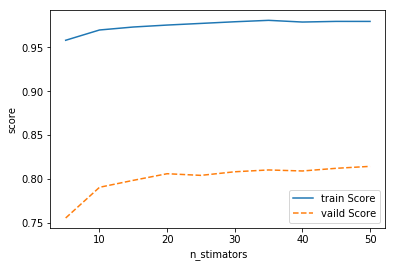

In [57]:
#최적 n 구하기 
train_score=[]
vaild_score=[]
para_n_tree=[n_tree*5 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf=RandomForestRegressor(n_estimators=v_n_estimators,random_state=1234)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    vaild_score.append(rf.score(df_vaild_x,df_vaild_y))
                      
df_score_n = pd.DataFrame()
df_score_n['n']=para_n_tree
df_score_n['trainScore']=train_score
df_score_n['vaildScore']=vaild_score

display(df_score_n.round(3))

plt.plot(para_n_tree,train_score,linestyle='-',label='train Score')
plt.plot(para_n_tree,vaild_score,linestyle='--',label='vaild Score')
plt.ylabel('score'); plt.xlabel('n_stimators')
plt.legend()
# vaildscore가 가장 높은 값을 채택한다.
#n=50

,MinSamplesLeaf,TrainScore,vaildScore
0,1,0.980,0.814
1,2,0.964,0.815
2,3,0.941,0.817
3,4,0.918,0.817
4,5,0.894,0.819
5,6,0.873,0.818
6,7,0.852,0.814
7,8,0.832,0.802
8,9,0.809,0.787
9,10,0.791,0.777


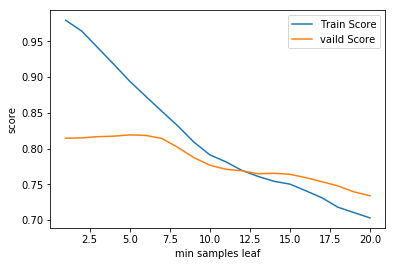

In [58]:
train_score=[]
vaild_score=[]
para_leaf=[n_leaf*1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf=RandomForestRegressor(random_state=1234,n_estimators=50,\
                             min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    vaild_score.append(rf.score(df_vaild_x,df_vaild_y))
                      
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf']=para_leaf
df_score_leaf['TrainScore']=train_score
df_score_leaf['vaildScore']=vaild_score
display(df_score_leaf.round(3))

plt.plot(para_leaf,train_score,linestyle='-',label='Train Score')
plt.plot(para_leaf,vaild_score,linestyle='-',label='vaild Score')
plt.ylabel('score'); plt.xlabel('min samples leaf')
plt.legend()
#vaildscore가 가장 큰 leaf를 5으로 선택한다.

,MinSamplessplit,TrainScore,vaildScore
0,4,0.894,0.819
1,6,0.894,0.819
2,8,0.894,0.819
3,10,0.894,0.819
4,12,0.890,0.817
5,14,0.884,0.817
6,16,0.878,0.816
7,18,0.867,0.808
8,20,0.857,0.802
9,22,0.847,0.794


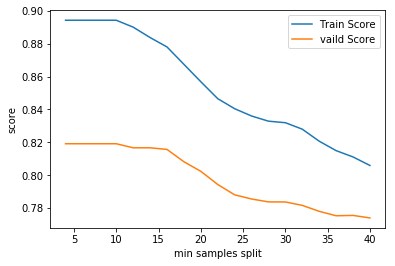

In [59]:
#최적 split 찾기
train_score=[]
vaild_score=[]
para_split=[n_split*2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf=RandomForestRegressor(random_state=1234,n_estimators=50,\
                             min_samples_leaf=5,min_samples_split=v_min_samples_split)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    vaild_score.append(rf.score(df_vaild_x,df_vaild_y))
              
df_score_split = pd.DataFrame()
df_score_split['MinSamplessplit']=para_split
df_score_split['TrainScore']=train_score
df_score_split['vaildScore']=vaild_score

display(df_score_split.round(3))

plt.plot(para_split,train_score,linestyle='-',label='Train Score')
plt.plot(para_split,vaild_score,linestyle='-',label='vaild Score')
plt.ylabel('score'); plt.xlabel('min samples split')
plt.legend()
#vaildscore가 크고 split값도 큰 10로 선택한다.

,depth,TrainScore,vaildScore
0,1,0.598,0.603
1,2,0.771,0.766
2,3,0.845,0.799
3,4,0.875,0.814
4,5,0.887,0.818
5,6,0.892,0.818
6,7,0.893,0.819
7,8,0.894,0.819
8,9,0.894,0.819
9,10,0.894,0.819


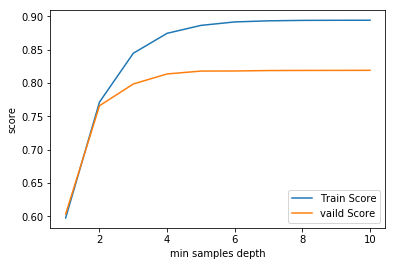

In [60]:
train_score=[]
vaild_score=[]
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf=RandomForestRegressor(random_state=1234,n_estimators=50,\
                             min_samples_leaf=5,min_samples_split=10\
                               ,max_depth=v_max_depth)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    vaild_score.append(rf.score(df_vaild_x,df_vaild_y))
                      
df_score_depth = pd.DataFrame()
df_score_depth['depth']=para_depth
df_score_depth['TrainScore']=train_score
df_score_depth['vaildScore']=vaild_score

display(df_score_depth.round(3))

plt.plot(para_depth,train_score,linestyle='-',label='Train Score')
plt.plot(para_depth,vaild_score,linestyle='-',label='vaild Score')
plt.ylabel('score'); plt.xlabel('min samples depth')
plt.legend()
#vaildscore가 가장 높은 값을 취하면 과적합의 가능성이 있기 때문에 두번쨰로 높고 depth가 작은 5을 사용한다. 

In [61]:
rf_final=RandomForestRegressor(random_state=1234,n_estimators=50,\
                             min_samples_leaf=5,min_samples_split=10\
                               ,max_depth=5)
rf_final.fit(df_train_x,df_train_y)
print('score on trainig set:{:.3f}'.format(rf_final.score(df_train_x,df_train_y)))
print('score on vaild set:{:.3f}'.format(rf_final.score(df_vaild_x,df_vaild_y)))
print('score on test set:{:.3f}'.format(rf_final.score(df_testx,df_testy)))
rf_final

#최종 모델이 train,vaild 둘다 높은 설명력을 가지며 test데이터에서도 0.873으로 높은 예측력을 가진다.

score on trainig set:0.887
score on vaild set:0.818
score on test set:0.873


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

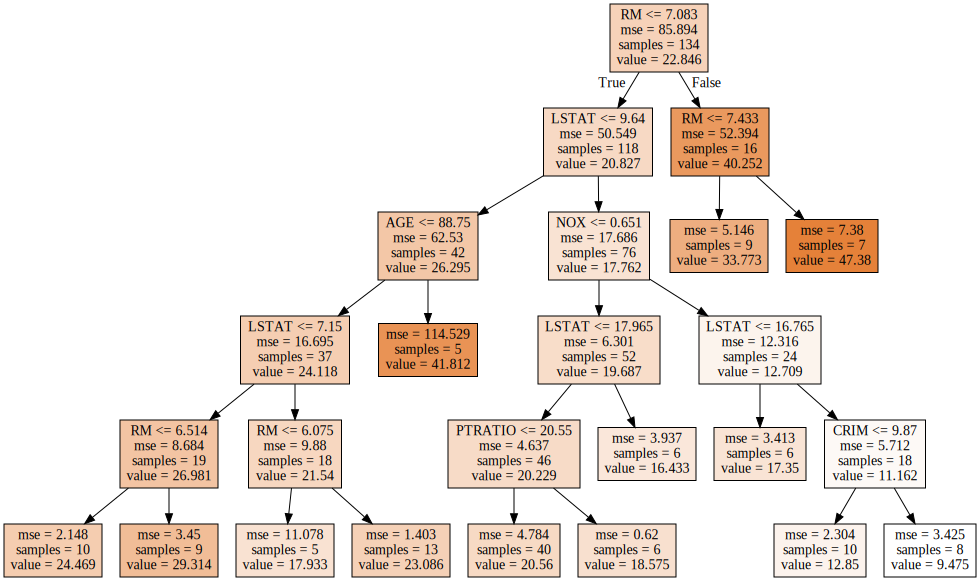

In [62]:
v_feature_names=df_train_x.columns

export_graphviz(rf_final.estimators_[0],out_file='rfr_final_0.dot',\
                feature_names=v_feature_names,impurity=True,filled=True)
with open('rfr_final_0.dot')as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))


# 로지스틱 회귀분석
## y를 이산형 변수인 강의 조망 여부(CHAS)로 한다.

In [40]:
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [47]:
#데이터 분할
df=pd.read_csv('BOSTON_HOUSING.csv',engine='python',encoding='949')
df=df.drop(['B'],axis=1,inplace=False)
display(df.head())
display(df.isnull().sum(axis=0))

df_train,df_test=train_test_split(df,test_size=0.6,random_state=1234)


print('train data  size:{}'.format(df_train.shape))
print('test data  size:{}'.format(df_test.shape))



,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,24.000000,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98
1,21.600000,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14
2,34.700001,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03
3,33.400002,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94
4,36.200001,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33


MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
dtype: int64

train data  size:(202, 13)
test data  size:(304, 13)


In [48]:
df_char=df.select_dtypes(include='object')
df_numeric=df.select_dtypes(exclude='object')
scaler=StandardScaler()
np_numeric_scaled=scaler.fit_transform(df_numeric)
df_numeric_scaled=pd.DataFrame(np_numeric_scaled,columns=df_numeric.columns)
df_scaled=pd.concat([df_numeric_scaled,df_char],axis=1)
df_scaled.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,0.159686,-0.419782,0.284830,-1.287910,-0.272599,-0.144218,0.413672,-0.120014,0.140214,-0.982843,-0.666608,-1.459000,-1.075562
1,-0.101524,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303095,-0.492439
2,1.324247,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303095,-1.208727
3,1.182758,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,-1.361517
4,1.487503,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228576,-0.511180,1.077737,-0.752922,-1.106115,0.113032,-1.026501


In [49]:
df_scaled['CHAS']=np.where(df_scaled['CHAS']>0,1,0)
df_scaled.head()

df_scaled_train,df_scaled_test=train_test_split(df_scaled,test_size=0.6,random_state=1234)


scaled_log_model=Logit.from_formula('CHAS~MEDV+CRIM+ZN+INDUS+NOX+RM+AGE+DIS+RAD+TAX+PTRATIO+LSTAT',df_scaled_train)
scaled_log_result=scaled_log_model.fit()
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.225897
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   CHAS   No. Observations:                  202
Model:                          Logit   Df Residuals:                      189
Method:                           MLE   Df Model:                           12
Date:                Sat, 04 May 2019   Pseudo R-squ.:                  0.1840
Time:                        21:50:40   Log-Likelihood:                -45.631
converged:                       True   LL-Null:                       -55.920
                                        LLR p-value:                   0.05692
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3136      0.510     -6.501      0.000      -4.313      -2.315
MEDV           1.2489      0.

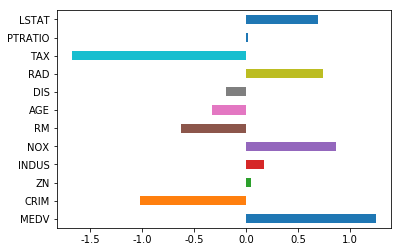

In [50]:
df_reg_coef=pd.DataFrame({'Coef':scaled_log_result.params.values[1:]},\
                         index=['MEDV','CRIM','ZN','INDUS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','LSTAT'])
df_reg_coef.plot.barh(y='Coef',legend=False)

In [51]:
scaled_log_model=Logit.from_formula('CHAS~MEDV+CRIM+ZN+INDUS+NOX+RM+AGE+DIS+RAD+TAX+LSTAT',df_scaled_train)
scaled_log_result=scaled_log_model.fit()
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.225899
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   CHAS   No. Observations:                  202
Model:                          Logit   Df Residuals:                      190
Method:                           MLE   Df Model:                           11
Date:                Sat, 04 May 2019   Pseudo R-squ.:                  0.1840
Time:                        21:50:51   Log-Likelihood:                -45.632
converged:                       True   LL-Null:                       -55.920
                                        LLR p-value:                   0.03804
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3134      0.509     -6.506      0.000      -4.311      -2.315
MEDV           1.2439      0.

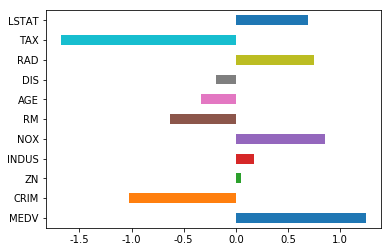

In [52]:
df_reg_coef=pd.DataFrame({'Coef':scaled_log_result.params.values[1:]},\
                         index=['MEDV','CRIM','ZN','INDUS','NOX','RM','AGE','DIS','RAD','TAX','LSTAT'])
df_reg_coef.plot.barh(y='Coef',legend=False)